# Imaging with Stride

In this notebook, we will apply what we have seen previously to image a 2D section of the human breast using full-waveform inversion (FWI) in Stride.

FWI is a tomographic imaging technique, originally developed in geophysics, that solves a local optimisation problem in order to find the acoustic properties (usually speed of sound) of some imaged region. 

Given some data that we have collected or observed $d_{obs}$ and some data that we have modelled numerically $d_{mod}$, FWI solves the problem,

$$
v_p^* = argmin_{v_p} J(v_p, d_{obs}, d_{mod})
$$
$$
s.t.\; \mathbf{L}(d_{mod}, v_p) = \mathbf{0}
$$

to find the speed of sound $v_p$, where $J(v_p, d_{obs}, d_{mod})$ is a scalar loss function and $\mathbf{L}(d_{mod},v_p) = \mathbf{0}$ is a system of PDEs.

Most generally, we use the L2-norm of the distance between $d_{obs}$ and $d_{mod}$ as the loss function, and the acoustic wave equation as the PDE. The problem then becomes,

$$
v_p^* = argmin_{v_p} \left\langle \frac{1}{2} \left( p(v_p) \delta(\mathbf{x}-\mathbf{x}_0) - d_{obs} \right) ^2, 1 \right\rangle
$$
$$
s.t.\; \frac{1}{v_p^2} \frac{\partial^2 p}{\partial t^2} - \nabla^2 p - s = 0
$$

where $\left\langle \alpha, \beta \right\rangle = \int_{t_0}^{t_1}\int_{\Omega} \alpha \cdot \beta d\mathbf{x}^3dt$ for $t \in [t_0, t_1]$ and $\mathbf{x} \in \Omega$, $\delta(x)$ is the sampling Dirac delta, $\mathbf{x}_0$ is the location of receivers in the region, $p$ is the pressure, and $s$ is a source term.

In FWI, we solve this problem by using a local optimisation method like gradient descent, and we calculate the gradient of the problem using the adjoint method or, what is the same, the procedure that we introduced in the first notebook of this tutorial.

## Mosaic runtime

Before we proceed, let's start the Mosaic runtime.

In [1]:
import mosaic

await mosaic.interactive('on', num_workers=2)
runtime = mosaic.runtime()

HEAD            Listening at <CommsManager object at 139982937110992, uid=head, address=CC2416, port=3000, state=listening>
MONITOR         Listening at <CommsManager object at 139983924024080, uid=monitor, address=CC2416, port=3005, state=listening>
WAREHOUSE       Listening at <CommsManager object at 139983923756048, uid=warehouse, address=CC2416, port=3007, state=listening>
NODE:0          Listening at <CommsManager object at 139983923770448, uid=node:0, address=CC2416, port=3008, state=listening>
WORKER:0:0      Listening at <CommsManager object at 139983923583760, uid=worker:0:0, address=CC2416, port=3009, state=listening>
WORKER:0:1      Listening at <CommsManager object at 139983923794384, uid=worker:0:1, address=CC2416, port=3010, state=listening>


## Problem definition

Let's start by defining out problem as usual, starting with the spatiotemporal grid.

In [2]:
from stride import Space, Time, Grid
%matplotlib notebook

space = Space(shape=(356, 385), extra=(50, 50), absorbing=(40, 40), spacing=0.5e-3)
time = Time(start=0.0e-6, step=0.08e-6, num=2500)

grid = Grid(space, time)

We create the problem object.

In [3]:
from stride import Problem

problem = Problem(name='breast2D', space=space, time=time)

And we start filling it up we our transducers and geometry.

In [4]:
# Create transducers
# the default option will create a single point transducer
problem.transducers.default()

# Create geometry
# a default elliptical geometry will be generated in this case
num_locations = 120
problem.geometry.default('elliptical', num_locations)

We are going to populate our acquisition sequence with 120 shots (one for each location in the geoemtry). During each shot, a different location is going to act as the source and the rest of them are going to act as receivers.

We can easily do this in Stride by calling the `default()` method of the `stride.Acquisitions` object.

In [5]:
from stride.utils import wavelets

# Populate acquisitions with default shots
problem.acquisitions.default()

# Create wavelets
f_centre = 0.50e6
n_cycles = 3

for shot in problem.acquisitions.shots:
    shot.wavelets.data[0, :] = wavelets.tone_burst(f_centre, n_cycles, time.num, time.step)

Now, let's load our breast model.

In [6]:
from stride import ScalarField

# Create medium
vp_true = ScalarField(name='vp', grid=grid)
vp_true.load('../examples/breast2D/data/anastasio2D-TrueModel.h5')

problem.medium.add(vp_true)

To get a plot of all components of the problem together, we can call the utility function `plot()` on the problem object.

<IPython.core.display.Javascript object>


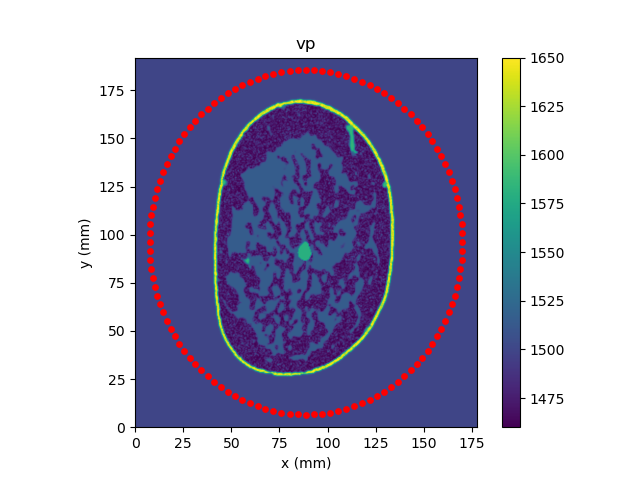

<IPython.core.display.Javascript object>


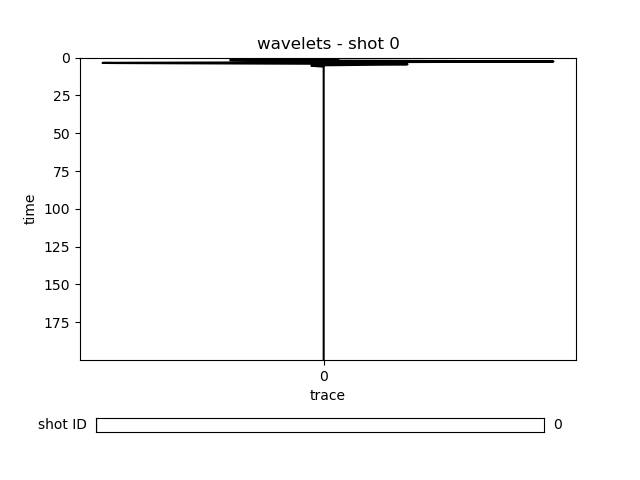

In [7]:
# Plot all components of the problem
problem.plot()

## Modelling operator

Once we have generated our problem, we can create a PDE on which to run our forward problem. In this case, we choose the isotropic acoustic wave equation.

We instantiate our PDE using `remote(len=<num>)` so that instances of the PDE are created in the workers for remote execution. We choose `len=runtime.num_workers` so that one instance is created in each available worker.

In [8]:
from stride import IsoAcousticDevito

pde = IsoAcousticDevito.remote(grid=problem.grid, len=runtime.num_workers)

WORKER:0:0      Default Devito configuration:
WORKER:0:1      Default Devito configuration:
WORKER:0:0      	 * autotuning=['aggressive', 'runtime']
WORKER:0:1      	 * autotuning=['aggressive', 'runtime']
WORKER:0:0      	 * develop-mode=False
WORKER:0:1      	 * develop-mode=False
WORKER:0:0      	 * mpi=False
WORKER:0:1      	 * mpi=False
WORKER:0:0      	 * log-level=DEBUG
WORKER:0:0      	 * language=openmp
WORKER:0:1      	 * log-level=DEBUG
WORKER:0:1      	 * language=openmp


## Forward problem - Generating observed data

Before we can proceed with the imaging bit, we need to simulate the acquisition of some observed data.

Here, we will exploit the parallelisation capabilities of Mosaic to run different shots in parallel in each available worker. We do this with an asynchronous for loop using `@runtime.async_for(<iterable>)`. In the previous code section, the async function `loop()` is called as many times as there are shots in the acquisitions and, for each shot, it is assigned a worker.

HEAD            Giving shot 0 to worker:0:0
HEAD            Giving shot 1 to worker:0:1
WORKER:0:0      (ShotID 0) Preparing to run state for shot
WORKER:0:0      (ShotID 0) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 0) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:0      (ShotID 0) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:0      (ShotID 0) Selected undersampling level 4
WORKER:0:0      (ShotID 0) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 1) Preparing to run state for shot
WORKER:0:1      (ShotID 1) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 1) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:1      (ShotID 1) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:1      (ShotID 1) Selected undersampling level 4
W

HEAD            Retrieved traces for shot 4
HEAD            Giving shot 5 to worker:0:1
WORKER:0:1      (ShotID 5) Preparing to run state for shot
WORKER:0:1      (ShotID 5) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 5) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:1      (ShotID 5) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:1      (ShotID 5) Selected undersampling level 4
WORKER:0:1      (ShotID 5) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 5) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Global performance: [OI=0.01, 39.82 GFlops/s, 1.08 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.51 s [OI=0.01, 40.35 GFlops/s, 1.09 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2

WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.46 s [OI=0.01, 45.36 GFlops/s, 1.23 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.04 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 3.03 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 9) Completed state equation run for shot
HEAD            Shot 9 retrieved
HEAD            Retrieved traces for shot 9
HEAD            Giving shot 11 to worker:0:1
WORKER:0:1      (ShotID 11) Preparing to run state for shot
WORKER:0:1      (ShotID 11) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 11) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:1      (ShotID 

WORKER:0:0      (ShotID 16) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:0      (ShotID 16) Selected undersampling level 4
WORKER:0:0      (ShotID 16) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 16) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.44 s
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.44 s
WORKER:0:1      Global performance: [OI=0.01, 47.62 GFlops/s, 1.29 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.43 s [OI=0.01, 48.32 GFlops/s, 1.31 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 3.26 GFlops/s]
WORKER:0:1      Performanc

WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 20) Completed state equation run for shot
HEAD            Shot 20 retrieved
HEAD            Retrieved traces for shot 20
HEAD            Giving shot 22 to worker:0:0
WORKER:0:0      (ShotID 22) Preparing to run state for shot
WORKER:0:0      (ShotID 22) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 22) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:0      (ShotID 22) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:0      (ShotID 22) Selected undersampling level 4
WORKER:0:0      (ShotID 22) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 22) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.43 s
WORKER:0:1      Global performance: [OI=0.01, 47.

WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.46 s
WORKER:0:0      Global performance: [OI=0.01, 44.78 GFlops/s, 1.21 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.46 s [OI=0.01, 45.43 GFlops/s, 1.23 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 3.01 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 26) Completed state equation run for shot
HEAD            Shot 26 retrieved
HEAD            Retrieved traces for shot 26
HEAD            Giving shot 28 to worker:0:0
WORKER:0:0      (ShotID 28) Preparing to run state for shot
WORKER:0:0     

HEAD            Retrieved traces for shot 31
HEAD            Giving shot 33 to worker:0:1
WORKER:0:1      (ShotID 33) Preparing to run state for shot
WORKER:0:1      (ShotID 33) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 33) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:1      (ShotID 33) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:1      (ShotID 33) Selected undersampling level 4
WORKER:0:1      (ShotID 33) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 33) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.43 s
WORKER:0:0      Global performance: [OI=0.01, 47.76 GFlops/s, 1.29 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.43 s [OI=0.01, 48.45 GFl

WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.44 s [OI=0.01, 46.99 GFlops/s, 1.27 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 3.10 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 37) Completed state equation run for shot
HEAD            Shot 37 retrieved
HEAD            Retrieved traces for shot 37
HEAD            Giving shot 39 to worker:0:1
WORKER:0:1      (ShotID 39) Preparing to run state for shot
WORKER:0:1      (ShotID 39) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 39) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm

WORKER:0:0      (ShotID 44) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:0      (ShotID 44) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:0      (ShotID 44) Selected undersampling level 4
WORKER:0:0      (ShotID 44) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 44) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.49 s
WORKER:0:1      Global performance: [OI=0.01, 41.94 GFlops/s, 1.13 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.49 s [OI=0.01, 42.50 GFlops/s, 1.15 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>

WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 3.38 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 48) Completed state equation run for shot
HEAD            Shot 48 retrieved
HEAD            Retrieved traces for shot 48
HEAD            Giving shot 50 to worker:0:0
WORKER:0:0      (ShotID 50) Preparing to run state for shot
WORKER:0:0      (ShotID 50) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 50) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:0      (ShotID 50) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:0      (ShotID 50) Selected undersampling level 4
WORKER:0:0      (ShotID 50) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 50) Running state equation for shot
WORKER:0:0      AutoTuner: c

WORKER:0:1      (ShotID 55) Selected undersampling level 4
WORKER:0:1      (ShotID 55) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 55) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Global performance: [OI=0.01, 48.12 GFlops/s, 1.30 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.43 s [OI=0.01, 48.82 GFlops/s, 1.32 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 3.26 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 54) Completed state equation run for shot
HEAD            Shot 54 retrieved
HEAD            Retrieved traces for shot 54

WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 59) Completed state equation run for shot
HEAD            Shot 59 retrieved
HEAD            Retrieved traces for shot 59
HEAD            Giving shot 61 to worker:0:1
WORKER:0:1      (ShotID 61) Preparing to run state for shot
WORKER:0:1      (ShotID 61) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 61) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:1      (ShotID 61) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:1      (ShotID 61) Selected undersampling level 4
WORKER:0:1      (ShotID 61) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 61) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Global performance: [OI=0.01, 49.32 GFlops/s, 1.33 GPts/s]
WORKER:0:0      Local performance:

WORKER:0:1      Operator `acoustic_iso_state` ran in 0.46 s
WORKER:0:1      Global performance: [OI=0.01, 45.11 GFlops/s, 1.22 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.45 s [OI=0.01, 45.80 GFlops/s, 1.24 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.04 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 3.01 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 65) Completed state equation run for shot
HEAD            Shot 65 retrieved
HEAD            Retrieved traces for shot 65
HEAD            Giving shot 67 to worker:0:1
WORKER:0:1      (ShotID 67) Preparing to run state for shot
WORKER:0:1      (ShotID 67) Estimated bandwidth for the propagated wa

HEAD            Giving shot 72 to worker:0:0
WORKER:0:0      (ShotID 72) Preparing to run state for shot
WORKER:0:0      (ShotID 72) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 72) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:0      (ShotID 72) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:0      (ShotID 72) Selected undersampling level 4
WORKER:0:0      (ShotID 72) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 72) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.44 s
WORKER:0:1      Global performance: [OI=0.01, 47.60 GFlops/s, 1.29 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.43 s [OI=0.01, 48.30 GFlops/s, 1.31 GPts/s]
WORKER:0:1        * secti

WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.43 s [OI=0.01, 48.58 GFlops/s, 1.31 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 3.32 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 76) Completed state equation run for shot
HEAD            Shot 76 retrieved
HEAD            Retrieved traces for shot 76
HEAD            Giving shot 78 to worker:0:0
WORKER:0:0      (ShotID 78) Preparing to run state for shot
WORKER:0:0      (ShotID 78) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 78) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:0      (Shot

WORKER:0:1      (ShotID 83) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 83) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:1      (ShotID 83) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:1      (ShotID 83) Selected undersampling level 4
WORKER:0:1      (ShotID 83) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 83) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Global performance: [OI=0.01, 48.00 GFlops/s, 1.30 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.43 s [OI=0.01, 48.72 GFlops/s, 1.32 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<

WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 3.18 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 87) Completed state equation run for shot
HEAD            Shot 87 retrieved
HEAD            Retrieved traces for shot 87
HEAD            Giving shot 89 to worker:0:1
WORKER:0:1      (ShotID 89) Preparing to run state for shot
WORKER:0:1      (ShotID 89) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 89) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:1      (ShotID 89) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:1      (ShotID 89) Selected undersampling level 4
WORKER:0:1      (ShotID

WORKER:0:0      (ShotID 94) Selected undersampling level 4
WORKER:0:0      (ShotID 94) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 94) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.43 s
WORKER:0:1      Global performance: [OI=0.01, 48.40 GFlops/s, 1.31 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.42 s [OI=0.01, 49.12 GFlops/s, 1.33 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 3.26 GFlops/s]
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.42 s
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 

HEAD            Shot 98 retrieved
HEAD            Retrieved traces for shot 98
HEAD            Giving shot 100 to worker:0:0
WORKER:0:0      (ShotID 100) Preparing to run state for shot
WORKER:0:0      (ShotID 100) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 100) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:0      (ShotID 100) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:0      (ShotID 100) Selected undersampling level 4
WORKER:0:0      (ShotID 100) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 100) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      (ShotID 99) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.45 s
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.45 s
WORKER:0:0      Global perfo

WORKER:0:0      (ShotID 105) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Global performance: [OI=0.01, 45.85 GFlops/s, 1.24 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.45 s [OI=0.01, 46.54 GFlops/s, 1.26 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.04 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 3.07 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 104) Completed state equation run for shot
HEAD            Shot 104 retrieved
HEAD            Retrieved traces for shot 104
HEAD            Giving shot 106 to worker:0:1
WORKER:0:1      (ShotID 106) Preparing to run state for shot
WORKER:0:

WORKER:0:1      (ShotID 109) Completed state equation run for shot
WORKER:0:0      Global performance: [OI=0.01, 49.33 GFlops/s, 1.33 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.41 s [OI=0.01, 50.04 GFlops/s, 1.35 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 3.36 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 110) Completed state equation run for shot
HEAD            Shot 110 retrieved
HEAD            Retrieved traces for shot 110
HEAD            Giving shot 111 to worker:0:0
WORKER:0:0      (ShotID 111) Preparing to run state for shot
WORKER:0:0      (ShotID 111) Estimated bandwidth for the 

WORKER:0:0      Global performance: [OI=0.01, 48.27 GFlops/s, 1.30 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.42 s [OI=0.01, 48.96 GFlops/s, 1.32 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 3.35 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 115) Completed state equation run for shot
HEAD            Shot 115 retrieved
HEAD            Retrieved traces for shot 115
HEAD            Giving shot 117 to worker:0:0
WORKER:0:0      (ShotID 117) Preparing to run state for shot
WORKER:0:0      (ShotID 117) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 117) Spa

<IPython.core.display.Javascript object>


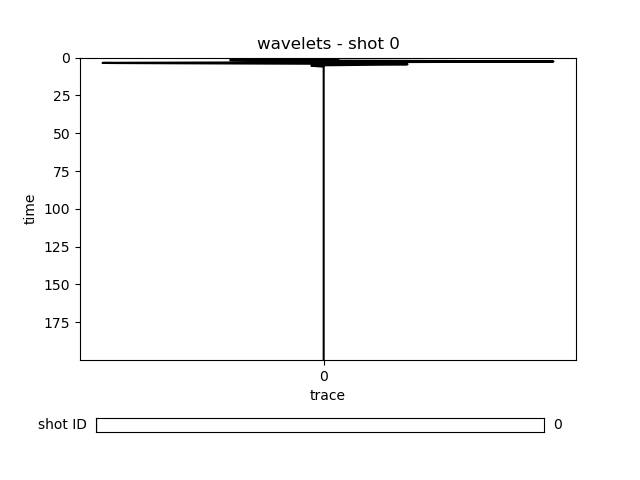

<IPython.core.display.Javascript object>


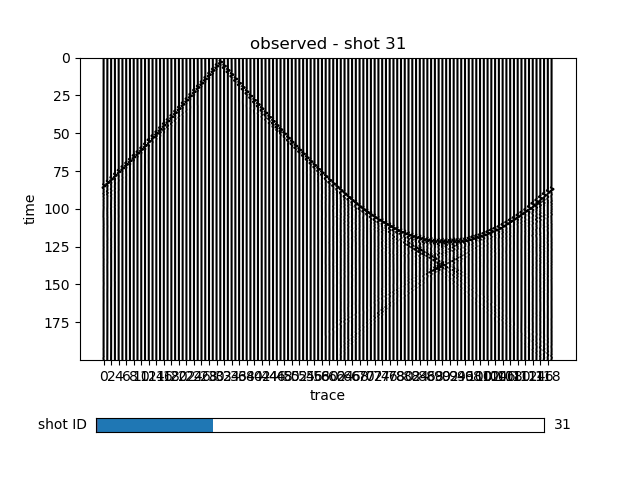

In [9]:
# Get all remaining shot IDs
shot_ids = problem.acquisitions.remaining_shot_ids

# Run an asynchronous loop across all shot IDs
@runtime.async_for(shot_ids)
async def loop(worker, shot_id):
    runtime.logger.info('Giving shot %d to %s' % (shot_id, worker.uid))

    # Fetch one sub-problem corresponding to a shot ID
    sub_problem = problem.sub_problem(shot_id)
    
    # Access the source wavelets of this shot
    wavelets = sub_problem.shot.wavelets
    
    # Execute the PDE forward
    traces = await pde(wavelets, vp_true,
                       problem=sub_problem,
                       runtime=worker).result()

    runtime.logger.info('Shot %d retrieved' % sub_problem.shot_id)

    # Store the retrieved traces into the shot
    shot = problem.acquisitions.get(shot_id)
    shot.observed.data[:] = traces.data

    runtime.logger.info('Retrieved traces for shot %d' % sub_problem.shot_id)

# Because this is an asynchronous loop, it needs to be awaited 
_ = await loop

# Plot the result
_ = problem.acquisitions.plot()

Because the loop we just ran is a very common piece of code, we can obtain the same result by running the utility function `forward()`:

In [ ]:
from stride import forward

# Run default forward workflow
# await forward(problem, pde, vp_true, dump=False)  # uncomment to run using utility function

## Starting model

Before we can proceed with the imaging process, we need to determine a starting point for our inversion, a starting model.

In [10]:
vp = ScalarField.parameter(name='vp', grid=grid, needs_grad=True)
vp.fill(1500.)

problem.medium.add(vp)

Unlike our forward example, the speed-of-sound field is unknown to us at this point. So, we define our starting guess for the speed of sound to be homogeneous with a value of 1500 m/s. Because we are going to run our inversion with respect to `vp`, we also define the field with `needs_grad=True`. That will instruct Stride to calculate the gradient of this variable when running the optimisation loop.

You can also see that the field has now been instantiated using `parameter()`. This will turn `vp` into a remotely addressable object. What this means is that, as `vp` travels through our Mosaic network, it will always keep a reference to its original object here in our code. This will effectively allow us to accumulate the gradients calculated across different workers into a single local buffer.

## Imaging operators

Apart from our PDE operator, which we have already defined above, we will need to define an operator for our loss function:

In [11]:
from stride import L2DistanceLoss 

loss = L2DistanceLoss.remote(len=runtime.num_workers)

We will also need some operators to proprocess the source wavelents and the modelled and observed data traces:

In [12]:
from stride import ProcessWavelets, ProcessTraces

process_wavelets = ProcessWavelets.remote(len=runtime.num_workers)
process_traces = ProcessTraces.remote(len=runtime.num_workers)

Finally, we will need an optimiser to update the speed of sound model after each iteration. In this case, we use gradient descent.

In [13]:
from stride import GradientDescent, ProcessGlobalGradient, ProcessModelIteration

step_size = 10
process_grad = ProcessGlobalGradient()
process_model = ProcessModelIteration(min=1400., max=1700.)

optimiser = GradientDescent(vp, step_size=step_size,
                            process_grad=process_grad,
                            process_model=process_model)

You can see that we have also provided to the optimiser some pre-defined processing steps. These will be used to prepare the gradient before updating the variable, and to process the variable after the update. 

Among other things, these processing steps will normalise and smooth the gradient, and will clip the speed of sound of the updated model between 1400 m/s and 1700 m/s.

## Inverse problem - Estimating speed of sound

We can now proceed to solve the inverse problem, that is finding the speed of sound that explains the data that we have generated above.

To obtain a better posed optimisation, we use a multi-scale approach. We will start our inversion by using only low frequencies to construct our model. As the inversion progresses, we will add higher frequencies until we reach the maximum desired level of detail.

We can do this by dividing our optimisation in `Block`s and specifying a maximum frequency. Each `Block` will run for a number of specified iterations.

During each iteration, only a subset of the shots will be used by defining the `select_shots` field. In this case, 15 shots will be used for each iteration, and they will be selected randomly without replacement.

HEAD            Starting iteration 1 (out of 4), block 1 (out of 2)
HEAD            Giving shot 1 to worker:0:0
HEAD            Giving shot 9 to worker:0:1
WORKER:0:0      (ShotID 1) Preparing to run state for shot
WORKER:0:0      (ShotID 1) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 1) Spatial grid spacing (0.500 mm | 4.082 PPW) is higher than dispersion limit (0.408 mm | 5.000 PPW)
WORKER:0:0      (ShotID 1) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.150 μs)
WORKER:0:0      (ShotID 1) Selected undersampling level 4
WORKER:0:0      (ShotID 1) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 9) Preparing to run state for shot
WORKER:0:1      (ShotID 9) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 9) Spatial grid spacing (0.500 mm | 4.082 PPW) is higher than dispersion limit (0.408 mm | 5.000 PPW)
WORKER:0:1      (ShotID 9) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0

WORKER:0:0      Operator `acoustic_iso_adjoint` fetched `/tmp/devito-jitcache-uid1000/1539214fca9dc22c6f19647423596a30c69ac0dd.c` in 1.15 s from jit-cache
WORKER:0:0      (ShotID 1) Running adjoint equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.58 s
WORKER:0:1      Global performance: [OI=0.01, 35.88 GFlops/s, 0.97 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.53 s [OI=0.01, 39.04 GFlops/s, 1.06 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.04 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.27 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 12) Completed state equat

HEAD            Retrieved gradient for shot 20
HEAD            Giving shot 30 to worker:0:1
WORKER:0:1      (ShotID 30) Preparing to run state for shot
WORKER:0:1      (ShotID 30) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 30) Spatial grid spacing (0.500 mm | 4.082 PPW) is higher than dispersion limit (0.408 mm | 5.000 PPW)
WORKER:0:1      (ShotID 30) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.150 μs)
WORKER:0:1      (ShotID 30) Selected undersampling level 4
WORKER:0:1      (ShotID 30) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 30) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.51 s
WORKER:0:0      Global performance: [OI=0.01, 40.55 GFlops/s, 1.10 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.47 s [OI=0.01, 44.33 G

HEAD            Retrieved gradient for shot 31
HEAD            Giving shot 47 to worker:0:0
WORKER:0:0      (ShotID 47) Preparing to run state for shot
WORKER:0:0      (ShotID 47) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 47) Spatial grid spacing (0.500 mm | 4.082 PPW) is higher than dispersion limit (0.408 mm | 5.000 PPW)
WORKER:0:0      (ShotID 47) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.150 μs)
WORKER:0:0      (ShotID 47) Selected undersampling level 4
WORKER:0:0      (ShotID 47) Selected time stepping scheme OT2
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 0.62 s
WORKER:0:0      (ShotID 47) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Global performance: [OI=0.01, 46.60 GFlops/s, 0.90 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.47 s [OI=0.01, 43.84

WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.04 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.51 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 112) Completed state equation run for shot
HEAD            Functional value for shot 112: loss 2.371833e+00 for shot 112
WORKER:0:1      (ShotID 112) Preparing to run adjoint for shot
WORKER:0:1      (ShotID 112) Running adjoint equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 0.65 s
WORKER:0:0      Global performance: [OI=0.01, 44.62 GFlops/s, 0.86 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.50 s [OI=0.01, 41.51 GFlops/s, 1.12 

WORKER:0:1      (ShotID 11) Preparing to run state for shot
WORKER:0:1      (ShotID 11) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 11) Spatial grid spacing (0.500 mm | 4.082 PPW) is higher than dispersion limit (0.408 mm | 5.000 PPW)
WORKER:0:1      (ShotID 11) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.150 μs)
WORKER:0:1      (ShotID 11) Selected undersampling level 4
WORKER:0:1      (ShotID 11) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 6) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      (ShotID 11) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.51 s
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.51 s
WORKER:0:0      Global performance: [OI=0.01, 40.30 GFlops/s, 1.09 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,4

WORKER:0:1      (ShotID 32) Completed adjoint equation run for shot
WORKER:0:0      Global performance: [OI=0.01, 38.11 GFlops/s, 0.74 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.56 s [OI=0.01, 37.06 GFlops/s, 1.00 GPts/s]
WORKER:0:0        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.43 GFlops/s, 0.04 GPts/s]
WORKER:0:0        * section2<2499,456,485> ran in 0.20 s [OI=0.94, 43.01 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 24) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 32
HEAD            Giving shot 44 to worker:0:1
HEAD            Retrieved gradient for shot 24
HEAD            Giving shot 52 to worker:0:0
WORKER:0:1      (ShotID 44) Preparing to run state for shot
WORKER:0:1      (ShotID 44) Estimated ban

WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.74 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 58) Completed state equation run for shot
HEAD            Functional value for shot 58: loss 2.415300e+00 for shot 58
WORKER:0:0      (ShotID 58) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 58) Running adjoint equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 0.65 s
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 0.64 s
WORKER:0:1      Global performance: [OI=0.01, 44.38 GFlops/s, 0.86 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<24

WORKER:0:0      (ShotID 81) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.58 s
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.76 s
WORKER:0:0      Global performance: [OI=0.01, 35.52 GFlops/s, 0.96 GPts/s]
WORKER:0:1      Global performance: [OI=0.01, 27.19 GFlops/s, 0.74 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:1      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.53 s [OI=0.01, 38.87 GFlops/s, 1.05 GPts/s]
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.70 s [OI=0.01, 29.66 GFlops/s, 0.80 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.04 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.04 GFlops/

WORKER:0:0      (ShotID 113) Selected time stepping scheme OT2
WORKER:0:1      Global performance: [OI=0.01, 41.34 GFlops/s, 0.80 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.52 s [OI=0.01, 39.59 GFlops/s, 1.07 GPts/s]
WORKER:0:1        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.45 GFlops/s, 0.04 GPts/s]
WORKER:0:1        * section2<2499,456,485> ran in 0.17 s [OI=0.94, 48.98 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 89) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 89
WORKER:0:0      (ShotID 113) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.49 s
WORKER:0:0      Global performance: [OI=0.01, 42.60 GFlops/s, 1.15 G

WORKER:0:1      (ShotID 35) Spatial grid spacing (0.500 mm | 4.082 PPW) is higher than dispersion limit (0.408 mm | 5.000 PPW)
WORKER:0:1      (ShotID 35) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.150 μs)
WORKER:0:1      (ShotID 35) Selected undersampling level 4
WORKER:0:1      (ShotID 35) Selected time stepping scheme OT2
HEAD            Retrieved gradient for shot 25
HEAD            Giving shot 38 to worker:0:0
WORKER:0:0      (ShotID 38) Preparing to run state for shot
WORKER:0:0      (ShotID 38) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 38) Spatial grid spacing (0.500 mm | 4.082 PPW) is higher than dispersion limit (0.408 mm | 5.000 PPW)
WORKER:0:0      (ShotID 38) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.150 μs)
WORKER:0:0      (ShotID 38) Selected undersampling level 4
WORKER:0:0      (ShotID 38) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 38) Running state equation for shot
WORKER:0:0     

WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.56 s [OI=0.01, 37.22 GFlops/s, 1.01 GPts/s]
WORKER:0:0        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.41 GFlops/s, 0.04 GPts/s]
WORKER:0:0        * section2<2499,456,485> ran in 0.20 s [OI=0.94, 42.24 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 62) Completed adjoint equation run for shot
WORKER:0:1      Global performance: [OI=0.01, 37.80 GFlops/s, 0.73 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.56 s [OI=0.01, 36.81 GFlops/s, 1.00 GPts/s]
WORKER:0:1        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=2.82, 1.35 GFlops/s, 0.03 GPts/s]
WORKER:0:1        * section2<2499,456,485> ran in 0.20 s [OI=0

WORKER:0:1      Global performance: [OI=0.01, 36.62 GFlops/s, 0.99 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.52 s [OI=0.01, 40.08 GFlops/s, 1.08 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.04 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.37 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 80) Completed state equation run for shot
HEAD            Functional value for shot 87: loss 3.101953e+00 for shot 87
HEAD            Functional value for shot 80: loss 2.984776e+00 for shot 80
WORKER:0:0      (ShotID 87) Preparing to run adjoint for shot
WORKER:0:1      (ShotID 80) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 87) Running a

WORKER:0:0      (ShotID 109) Spatial grid spacing (0.500 mm | 4.082 PPW) is higher than dispersion limit (0.408 mm | 5.000 PPW)
WORKER:0:0      (ShotID 109) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.150 μs)
WORKER:0:0      (ShotID 109) Selected undersampling level 4
WORKER:0:0      (ShotID 109) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 106) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      (ShotID 109) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.51 s
WORKER:0:1      Global performance: [OI=0.01, 40.89 GFlops/s, 1.11 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.46 s [OI=0.01, 44.99 GFlops/s, 1.22 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.

WORKER:0:1      (ShotID 19) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      (ShotID 4) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.47 s
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.51 s
WORKER:0:1      Global performance: [OI=0.01, 43.70 GFlops/s, 1.18 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.43 s [OI=0.01, 48.21 GFlops/s, 1.30 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.78 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 19) Comp

WORKER:0:0        * section2<2499,456,485> ran in 0.17 s [OI=0.94, 49.82 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 39) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 39
HEAD            Giving shot 60 to worker:0:0
WORKER:0:1      (ShotID 43) Preparing to run state for shot
WORKER:0:1      (ShotID 43) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 43) Spatial grid spacing (0.500 mm | 4.082 PPW) is higher than dispersion limit (0.408 mm | 5.000 PPW)
WORKER:0:1      (ShotID 43) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.150 μs)
WORKER:0:1      (ShotID 43) Selected undersampling level 4
WORKER:0:1      (ShotID 43) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 60) Preparing to run state for shot
WORKER:0:0      (ShotID 60) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (Sh

WORKER:0:0      (ShotID 90) Running adjoint equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 0.68 s
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 0.64 s
WORKER:0:1      Global performance: [OI=0.01, 42.65 GFlops/s, 0.82 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.50 s [OI=0.01, 41.64 GFlops/s, 1.13 GPts/s]
WORKER:0:1        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.56 GFlops/s, 0.04 GPts/s]
WORKER:0:1        * section2<2499,456,485> ran in 0.18 s [OI=0.94, 47.64 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 69) Completed adjoint equation run for shot
WORKER:0:0      Global performance: [OI=0.01, 45.13 GFlops/s, 0.87 GPts/s]
WORKER:0:0      Local performance:
WOR

WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.70 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 98) Completed state equation run for shot
WORKER:0:0      Global performance: [OI=0.01, 44.18 GFlops/s, 1.19 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.43 s [OI=0.01, 48.54 GFlops/s, 1.31 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.87 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 101) Completed state equation run for shot
HEAD            

WORKER:0:0      (ShotID 107) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 107
WORKER:0:1      (ShotID 108) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.46 s
WORKER:0:1      Global performance: [OI=0.01, 45.23 GFlops/s, 1.22 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.42 s [OI=0.01, 49.52 GFlops/s, 1.34 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.88 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 108) Completed state equation run for shot
HEAD            Func

WORKER:0:1      (ShotID 22) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.150 μs)
WORKER:0:1      (ShotID 22) Selected undersampling level 4
WORKER:0:1      (ShotID 22) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 21) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      (ShotID 22) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.48 s
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.47 s
WORKER:0:0      Global performance: [OI=0.01, 43.22 GFlops/s, 1.17 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.44 s [OI=0.01, 47.61 GFlops/s, 1.29 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,1

WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.52 s [OI=0.01, 39.69 GFlops/s, 1.07 GPts/s]
WORKER:0:1        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.40 GFlops/s, 0.04 GPts/s]
WORKER:0:1        * section2<2499,456,485> ran in 0.17 s [OI=0.94, 49.33 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 41) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 41
HEAD            Giving shot 59 to worker:0:1
WORKER:0:1      (ShotID 59) Preparing to run state for shot
WORKER:0:1      (ShotID 59) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 59) Spatial grid spacing (0.500 mm | 4.082 PPW) is higher than dispersion limit (0.408 mm | 5.000 PPW)
WORKER:0:1      (ShotID 59) Time grid spacing (0.080 μs | 

WORKER:0:0      (ShotID 72) Preparing to run adjoint for shot
HEAD            Functional value for shot 67: loss 2.501029e+00 for shot 67
WORKER:0:0      (ShotID 72) Running adjoint equation for shot
WORKER:0:1      (ShotID 67) Preparing to run adjoint for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      (ShotID 67) Running adjoint equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 0.67 s
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 0.67 s
WORKER:0:0      Global performance: [OI=0.01, 43.27 GFlops/s, 0.83 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.48 s [OI=0.01, 43.57 GFlops/s, 1.18 GPts/s]
WORKER:0:0        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.57 GFlops/s, 0.04 GPts/s]
WORKER:0:0        * section2<2499,456,485> 

WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.51 s [OI=0.01, 40.23 GFlops/s, 1.09 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.04 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.33 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 92) Completed state equation run for shot
HEAD            Functional value for shot 92: loss 3.322180e+00 for shot 92
WORKER:0:1      (ShotID 92) Preparing to run adjoint for shot
WORKER:0:1      (ShotID 92) Running adjoint equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Global performance: [OI=0.01, 31.72 GFlops/s, 0.86 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * sect

WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 0) Completed state equation run for shot
WORKER:0:1      Global performance: [OI=0.01, 40.52 GFlops/s, 1.10 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.46 s [OI=0.01, 44.91 GFlops/s, 1.21 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.64 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 8) Completed state equation run for shot
HEAD            Functional value for shot 0: loss 1.821723e+00 for shot 0
HEAD            Functional value for shot 8: loss 2.305756e+00 for shot 8
WORKER

HEAD            Giving shot 64 to worker:0:0
WORKER:0:0      (ShotID 64) Preparing to run state for shot
WORKER:0:0      (ShotID 64) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 64) Spatial grid spacing (0.500 mm | 4.082 PPW) is higher than dispersion limit (0.408 mm | 5.000 PPW)
WORKER:0:0      (ShotID 64) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.150 μs)
WORKER:0:0      (ShotID 64) Selected undersampling level 4
WORKER:0:0      (ShotID 64) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 57) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      (ShotID 64) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.48 s
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.48 s
WORKER:0:1      Global performance: [OI=0.01, 43.07 GFlops/s, 1.16 GPts/s]
WORKER:0:1      Local performance:
WORKE

WORKER:0:1      (ShotID 68) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 68
HEAD            Giving shot 82 to worker:0:1
WORKER:0:1      (ShotID 82) Preparing to run state for shot
WORKER:0:1      (ShotID 82) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 82) Spatial grid spacing (0.500 mm | 4.082 PPW) is higher than dispersion limit (0.408 mm | 5.000 PPW)
WORKER:0:1      (ShotID 82) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.150 μs)
WORKER:0:1      (ShotID 82) Selected undersampling level 4
WORKER:0:1      (ShotID 82) Selected time stepping scheme OT2
WORKER:0:0      Global performance: [OI=0.01, 45.29 GFlops/s, 0.87 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.46 s [OI=0.01, 45.10 GFlops/s, 1.22 GPts/s]
WORKER:0:0        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>>

WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 96) Completed state equation run for shot
HEAD            Functional value for shot 96: loss 3.161884e+00 for shot 96
WORKER:0:0      (ShotID 96) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 96) Running adjoint equation for shot
HEAD            Functional value for shot 95: loss 3.271927e+00 for shot 95
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      (ShotID 95) Preparing to run adjoint for shot
WORKER:0:1      (ShotID 95) Running adjoint equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 0.68 s
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 0.68 s
WORKER:0:0      Global performance: [OI=0.01, 42.41 GFlops/s, 0.82 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,4

WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 118) Completed state equation run for shot
HEAD            Functional value for shot 118: loss 2.653304e+00 for shot 118
WORKER:0:1      (ShotID 118) Preparing to run adjoint for shot
WORKER:0:1      (ShotID 118) Running adjoint equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 0.48 s
WORKER:0:1      Global performance: [OI=0.01, 60.63 GFlops/s, 1.17 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.41 s [OI=0.01, 50.90 GFlops/s, 1.38 GPts/s]
WORKER:0:1        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.87 GFlops/s, 0.05 GPts/s]
WORKER:0:1        * section2<2499,456,485> ran in 0.07 s [OI=0.94, 127.86 GFlops/s]
WORKER:0:1      Performance[mode=

WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.59 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 17) Completed state equation run for shot
HEAD            Functional value for shot 17: loss 3.239941e+00 for shot 17
WORKER:0:0      (ShotID 17) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 17) Running adjoint equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Global performance: [OI=0.01, 39.31 GFlops/s, 1.06 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.48 s [OI=0.01, 42.89 GFlops/s, 1.16 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<24

WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 40) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 40
HEAD            Giving shot 53 to worker:0:1
WORKER:0:1      (ShotID 53) Preparing to run state for shot
WORKER:0:1      (ShotID 53) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 53) Spatial grid spacing (0.500 mm | 4.082 PPW) is higher than dispersion limit (0.408 mm | 5.000 PPW)
WORKER:0:1      (ShotID 53) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.150 μs)
WORKER:0:1      (ShotID 53) Selected undersampling level 4
WORKER:0:1      (ShotID 53) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 51) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      (ShotID 53) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator 

WORKER:0:0        * section2<2499,456,485> ran in 0.18 s [OI=0.94, 48.17 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 55) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 55
HEAD            Giving shot 65 to worker:0:0
WORKER:0:0      (ShotID 65) Preparing to run state for shot
WORKER:0:0      (ShotID 65) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 65) Spatial grid spacing (0.500 mm | 4.082 PPW) is higher than dispersion limit (0.408 mm | 5.000 PPW)
WORKER:0:0      (ShotID 65) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.150 μs)
WORKER:0:0      (ShotID 65) Selected undersampling level 4
WORKER:0:0      (ShotID 65) Selected time stepping scheme OT2
WORKER:0:1      Global performance: [OI=0.01, 44.78 GFlops/s, 0.86 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2

WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.64 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 71) Completed state equation run for shot
HEAD            Functional value for shot 97: loss 2.928810e+00 for shot 97
HEAD            Functional value for shot 71: loss 2.762550e+00 for shot 71
WORKER:0:0      (ShotID 97) Preparing to run adjoint for shot
WORKER:0:1      (ShotID 71) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 97) Running adjoint equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      (ShotID 71) Running adjoint equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 0.67 s
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 0.68 s
WORKER:0:1      Global performance: [OI=0.01, 43.15 GFlops/s, 0.83 GPts/

WORKER:0:1      (ShotID 5) Completed state equation run for shot
WORKER:0:0      (ShotID 2) Running adjoint equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
HEAD            Functional value for shot 5: loss 2.761344e+00 for shot 5
WORKER:0:1      (ShotID 5) Preparing to run adjoint for shot
WORKER:0:1      (ShotID 5) Running adjoint equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 0.67 s
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 0.68 s
WORKER:0:0      Global performance: [OI=0.01, 43.23 GFlops/s, 0.83 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.50 s [OI=0.01, 41.65 GFlops/s, 1.13 GPts/s]
WORKER:0:0        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.58 GFlops/s, 0.04 GPts/s]
WORKER:0:0        * section2<2499,456,485> ra

WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.46 s [OI=0.01, 45.56 GFlops/s, 1.23 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.04 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.51 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 26) Completed state equation run for shot
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.48 s
HEAD            Functional value for shot 26: loss 4.184630e+00 for shot 26
WORKER:0:0      (ShotID 26) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 26) Running adjoint equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Global performance: [OI=0.01, 43.00 GFlops/s, 1.16 GPts/s]
WORKER:0:1      Local performance:

WORKER:0:1        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.56 GFlops/s, 0.04 GPts/s]
WORKER:0:1        * section2<2499,456,485> ran in 0.16 s [OI=0.94, 53.58 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 45) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 45
HEAD            Giving shot 63 to worker:0:1
WORKER:0:1      (ShotID 63) Preparing to run state for shot
WORKER:0:1      (ShotID 63) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 63) Spatial grid spacing (0.500 mm | 4.082 PPW) is higher than dispersion limit (0.408 mm | 5.000 PPW)
WORKER:0:1      (ShotID 63) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.150 μs)
WORKER:0:1      (ShotID 63) Selected undersampling level 4
WORKER:0:1      (ShotID 63) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 49) Runni

WORKER:0:0        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.46 GFlops/s, 0.04 GPts/s]
WORKER:0:0        * section2<2499,456,485> ran in 0.17 s [OI=0.94, 50.84 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 86) Completed adjoint equation run for shot
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 0.65 s
HEAD            Retrieved gradient for shot 86
HEAD            Giving shot 102 to worker:0:0
WORKER:0:0      (ShotID 102) Preparing to run state for shot
WORKER:0:0      (ShotID 102) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 102) Spatial grid spacing (0.500 mm | 4.082 PPW) is higher than dispersion limit (0.408 mm | 5.000 PPW)
WORKER:0:0      (ShotID 102) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.150 μs)
WORKER:0:0      (ShotID 102) Selected undersampling level 4
WORKER:0:0      (ShotID 102

WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 117) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 117
HEAD            Updating variable vp,
HEAD            	 direction before processing in range [-2.798743e+02, 4.723666e+02]
HEAD            	 direction after processing in range [-5.929215e-01, 1.000000e+00]
HEAD            	 variable range before update [1.450676e+03, 1.521628e+03]
HEAD            	 variable range after update [1.443174e+03, 1.522438e+03]
HEAD            Done iteration 4 (out of 4), block 2 (out of 2) - Total loss_freq 4.137792e+01
HEAD            ====================================================================


<IPython.core.display.Javascript object>


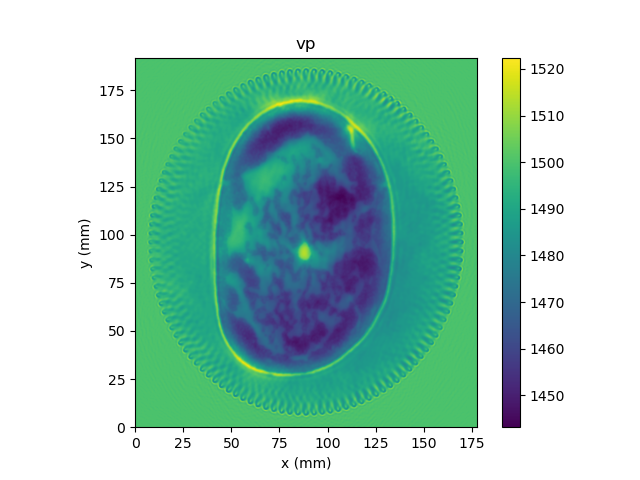

<AxesSubplot:title={'center':'vp'}, xlabel='x (mm)', ylabel='y (mm)'>

In [14]:
from stride import OptimisationLoop

# Clear the previous Devito operators
await pde.clear_operators()

optimisation_loop = OptimisationLoop()

# Specify a series of frequency bands, which we will introduce gradually 
# into the inversion in order to better condition it
f_min = 0.05e6
max_freqs = [0.3e6, 0.4e6]

num_blocks = len(max_freqs)
num_iters = 4

# Start iterating over each block in the optimisation
for block, f_max in optimisation_loop.blocks(num_blocks, max_freqs):

    # Proceed through every iteration in the block
    for iteration in block.iterations(num_iters):
        runtime.logger.info('Starting iteration %d (out of %d), '
                            'block %d (out of %d)' %
                            (iteration.id+1, block.num_iterations, block.id+1,
                             optimisation_loop.num_blocks))

        # Select some shots for this iteration
        shot_ids = problem.acquisitions.select_shot_ids(num=15, randomly=True)

        # Clear the gradient buffers of the variable
        vp.clear_grad()
        
        # Make latest version of the variable available for the workers
        await vp.push()

        # Asynchronously loop over all the selected shot IDs
        @runtime.async_for(shot_ids)
        async def loop(worker, shot_id):
            runtime.logger.info('Giving shot %d to %s' % (shot_id, worker.uid))

            # Fetch one sub-problem corresponding to the shot ID
            sub_problem = problem.sub_problem(shot_id)
            wavelets = sub_problem.shot.wavelets
            observed = sub_problem.shot.observed

            # Pre-process the wavelets
            wavelets = process_wavelets(wavelets, f_min=f_min, f_max=f_max, runtime=worker)
            # Execute the PDE forward
            modelled = pde(wavelets, vp, problem=sub_problem, runtime=worker)

            # Pre-process the modelled and observed traces
            traces = process_traces(modelled, observed, f_min=f_min, f_max=f_max, runtime=worker)
            # and use these pre-processed versions to calculate the
            # value of the loss_freq function
            fun = await loss(traces.outputs[0], traces.outputs[1],
                             problem=sub_problem, runtime=worker).result()

            iteration.add_fun(fun)
            runtime.logger.info('Functional value for shot %d: %s' % (shot_id, fun))

            # Now, we can calculate the gradient by executing the adjoint of the
            # forward process
            await fun.adjoint()

            runtime.logger.info('Retrieved gradient for shot %d' % sub_problem.shot_id)

        # Because this is an async loop, it needs to be awaited    
        _ = await loop
        # Bring to the local process the accumulated gradient
        await vp.pull()
        # Update the vp with the calculated gradient by taking a step with the optimiser
        await optimiser.step()

        runtime.logger.info('Done iteration %d (out of %d), '
                            'block %d (out of %d) - Total loss_freq %e' %
                            (iteration.id+1, block.num_iterations, block.id+1,
                             optimisation_loop.num_blocks, iteration.fun_value))
        runtime.logger.info('====================================================================')

# Plot the vp afterwards   
vp.plot()

As was the case for the forward example, we can obtain the same result by using a utility function that will run the default inversion workflow using `adjoint`:

In [ ]:
# uncomment to run using utility function
# for block, freq in optimisation_loop.blocks(num_blocks, max_freqs):
#     await adjoint(problem, pde, loss_freq,
#                   optimisation_loop, optimiser, vp,
#                   num_iters=num_iters,
#                   select_shots=dict(num=15, randomly=True),
#                   f_min=0.05e6, f_max=freq)

# vp.plot()

Before closing, we should tear down the mosaic runtime:

In [15]:
await mosaic.interactive('off')